In [67]:
import numpy as np 
import pandas as pd
import cvxpy as cp 
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.optimize import minimize

In [68]:
# Pull 1 years worth of dailiy price data for 4 stocks from yahoo finance
tickers = sorted(['AAPL', 'F', 'VZ', 'KO'])
start = '2023-01-01'
end = '2023-12-31'

data = yf.download(tickers, start, end, )

prices = data['Adj Close']

prices.head()

[*********************100%***********************]  4 of 4 completed


Ticker,AAPL,F,KO,VZ
Date,,,,
2023-01-03 00:00:00+00:00,123.768456,9.878721,59.665295,35.586952
2023-01-04 00:00:00+00:00,125.045029,10.157828,59.636852,36.482838
2023-01-05 00:00:00+00:00,123.718987,10.360815,58.954422,36.988430
2023-01-06 00:00:00+00:00,128.271088,10.639924,60.091808,37.423065
2023-01-09 00:00:00+00:00,128.795578,10.732960,59.343033,37.272602


In [69]:
# Turn the raw price data into a daily returns dataframe
returns = prices.pct_change()
returns.head()

Ticker,AAPL,F,KO,VZ
Date,,,,
2023-01-03 00:00:00+00:00,NaN,NaN,NaN,NaN
2023-01-04 00:00:00+00:00,0.010314,0.028253,-0.000477,0.025175
2023-01-05 00:00:00+00:00,-0.010605,0.019983,-0.011443,0.013858
2023-01-06 00:00:00+00:00,0.036794,0.026939,0.019293,0.011751
2023-01-09 00:00:00+00:00,0.004089,0.008744,-0.012461,-0.004021


In [70]:
# Take the average historical return as a expected return vector for testing
# In practice this vector would be computed with signal research
expected_returns = returns.mean()

expected_returns.reset_index().rename(columns={0: 'E[r]'})

,Ticker,E[r]
0,AAPL,0.001835
1,F,0.000822
2,KO,-0.000104
3,VZ,0.000138


In [71]:
# Take the historical convariance matrix of the returns dataframe
# In practice this matrix would be forecasted with signal research
covariance_matrix = returns.cov()

covariance_matrix

Ticker,AAPL,F,KO,VZ
Ticker,,,,
AAPL,0.000158,0.000068,0.000021,0.000028
F,0.000068,0.000495,0.000021,0.000076
KO,0.000021,0.000021,0.000072,0.000036
VZ,0.000028,0.000076,0.000036,0.000209


In [72]:
# Formulate optimization problem
# We want to maximize expected return while penalizing variance scaled by our risk aversion (gamma)

def optimal_portfolio(gamma):
    weights = cp.Variable(len(tickers))

    objective = cp.Maximize(weights @ expected_returns - gamma * (weights.T @ covariance_matrix @ weights))

    problem = cp.Problem(objective)
    problem.solve()

    return weights.value

In [73]:
# Generate optimal portfolios fo different levels of gamma

optimal_portfolios = []

for gamma in range(1,11):

    optimal_weights = optimal_portfolio(gamma)

    expected_return = optimal_weights @ expected_returns
    volatility = np.sqrt(optimal_weights.T @ covariance_matrix @ optimal_weights)
    sharpe = expected_return / volatility

    result = list(optimal_weights) + [gamma, expected_return, volatility, sharpe]

    optimal_portfolios.append(result)

headers = tickers + ['Gamma', 'E[r]', 'Vol', 'Sharpe']
df = pd.DataFrame(data=optimal_portfolios, columns=headers)

df

,AAPL,F,KO,VZ,Gamma,E[r],Vol,Sharpe
0,6.115245,0.104726,-2.531539,-0.075249,1,0.011561,0.076029,0.152058
1,3.057623,0.052363,-1.265769,-0.037624,2,0.005780,0.038015,0.152058
2,2.038415,0.034909,-0.843846,-0.025083,3,0.003854,0.025343,0.152058
3,1.528811,0.026181,-0.632885,-0.018812,4,0.002890,0.019007,0.152058
4,1.223049,0.020945,-0.506308,-0.015050,5,0.002312,0.015206,0.152058
5,1.019208,0.017454,-0.421923,-0.012541,6,0.001927,0.012672,0.152058
6,0.873606,0.014961,-0.361648,-0.010750,7,0.001652,0.010861,0.152058
7,0.764406,0.013091,-0.316442,-0.009406,8,0.001445,0.009504,0.152058
8,0.679472,0.011636,-0.281282,-0.008361,9,0.001285,0.008448,0.152058
9,0.611525,0.010473,-0.253154,-0.007525,10,0.001156,0.007603,0.152058


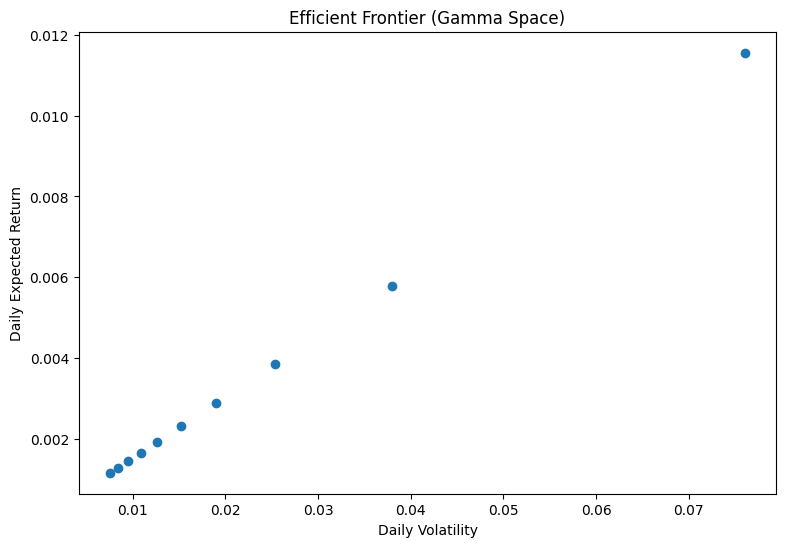

In [74]:
plt.figure(figsize=(9,6))
plt.title("Efficient Frontier (Gamma Space)")
plt.ylabel("Daily Expected Return")
plt.xlabel("Daily Volatility")
plt.scatter(df['Vol'], df['E[r]'])
plt.show()

Notice that all of these portfolios have the same sharpe ratio. Our gamma value scales the leverage that we apply to the portfolio.

In [75]:
# In order to get the optimal portfolio weights for a fully invested portfolio
# we first get the optimal weights for some arbitrary level of gamma
# and then we scale the weights so that they sum to 1

optimal_portfolio_weights = optimal_portfolio(1) / np.sum(optimal_portfolio(1))

optimal_expected_return = optimal_portfolio_weights @ expected_returns
optimal_volatility = np.sqrt(optimal_portfolio_weights.T @ covariance_matrix @ optimal_portfolio_weights)
optimal_sharpe = optimal_expected_return / optimal_volatility

In [76]:
# Here we use scipy to minimize the volalitity while keeping a target return
# This will allow us to graph the efficient frontier

def volatility(weights, covariance_matrix):
    return np.sqrt(np.dot(weights, np.dot(covariance_matrix, weights)))

def mve_portfolio(target_return, covariance_matrix, expected_returns):
    n = len(expected_returns)
    
    objective = lambda weights: volatility(weights, covariance_matrix)
    
    constraints = ({'type': 'eq', 'fun': lambda x: np.dot(x, expected_returns) - target_return},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    
    result = minimize(objective, n * [1 / n], method='SLSQP', constraints=constraints)
    
    return result.x

In [77]:
# Generate a bunch of mean variance efficient portfolios
mve_portfolios = []

target_returns = np.linspace(0, 2 * optimal_expected_return, 100)

for target_return in target_returns:

    optimal_weights = mve_portfolio(target_return, covariance_matrix, expected_returns)

    expected_return = np.dot(optimal_weights, expected_returns)
    vol = np.sqrt(np.dot(optimal_weights, np.dot(covariance_matrix, optimal_weights)))
    sharpe = expected_return / vol
    
    result = list(optimal_weights) + [expected_return, vol, sharpe]
    mve_portfolios.append(result)

headers = tickers + ['E[r]', 'Vol', 'Sharpe']
df = pd.DataFrame(data=mve_portfolios, columns=headers)

df

,AAPL,F,KO,VZ,E[r],Vol,Sharpe
0,0.019292,0.039482,0.816138,0.125088,1.780004e-14,0.007898,2.253786e-12
1,0.053767,0.037604,0.785513,0.123115,6.463901e-05,0.007750,8.340834e-03
2,0.087658,0.037055,0.754542,0.120745,1.292780e-04,0.007626,1.695229e-02
3,0.119787,0.040142,0.721494,0.118578,1.939170e-04,0.007528,2.575854e-02
4,0.155352,0.036987,0.694893,0.112768,2.585560e-04,0.007456,3.467783e-02
...,...,...,...,...,...,...,...
95,3.228589,0.023005,-2.097612,-0.153982,6.140706e-03,0.041031,1.496594e-01
96,3.262351,0.022874,-2.128304,-0.156920,6.205345e-03,0.041478,1.496060e-01
97,3.296119,0.022738,-2.158967,-0.159890,6.269984e-03,0.041925,1.495532e-01
98,3.329890,0.022604,-2.189600,-0.162895,6.334623e-03,0.042372,1.495010e-01


In [78]:
# Create a datafrmae of the individual asset properties

expected_returns = expected_returns.to_numpy()
volatilities = np.sqrt(covariance_matrix.to_numpy().diagonal())
sharpes = expected_returns / volatilities

stocks = pd.DataFrame(
    data=[expected_returns, volatilities, sharpes], 
    columns=tickers
    )
stocks = stocks.T.rename(columns={0: 'expected_return', 1: 'volatility', 2: 'sharpe'})

stocks

,expected_return,volatility,sharpe
AAPL,0.001835,0.012570,0.145976
F,0.000822,0.022245,0.036946
KO,-0.000104,0.008474,-0.012314
VZ,0.000138,0.014468,0.009569


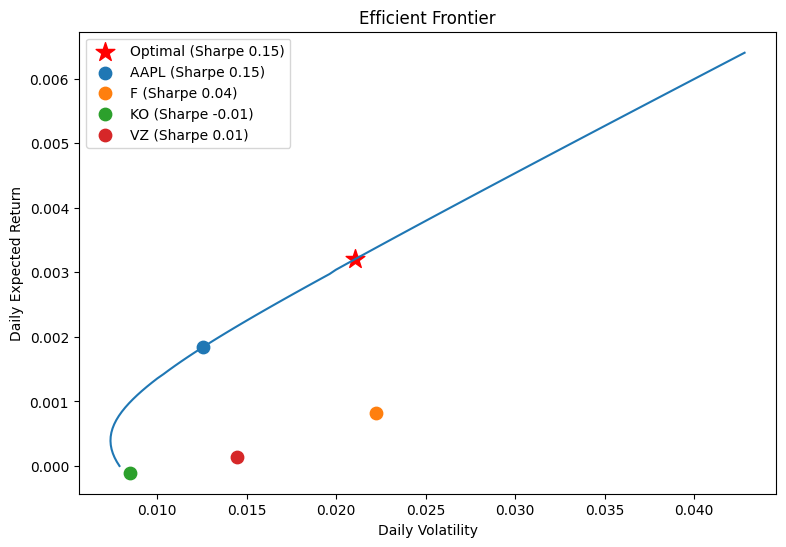

In [79]:
# Plot the efficient frontier

plt.figure(figsize=(9,6))
plt.title("Efficient Frontier")
plt.ylabel("Daily Expected Return")
plt.xlabel("Daily Volatility")

# MVE Portfolios
plt.plot(df['Vol'], df['E[r]'])

# Optimal Portfolio
plt.scatter(optimal_volatility,optimal_expected_return, marker="*", color='red', s=200, label=f"Optimal (Sharpe {round(optimal_sharpe,2)})")

# Individual assets
for index, stock in stocks.iterrows():
    plt.scatter(stock['volatility'], stock['expected_return'], label=f"{index} (Sharpe {round(stock['sharpe'],2)})", s=80)

plt.legend()
plt.show()